In [2]:
import sys
sys.path.insert(0, '../src/')

import pickle
import warnings
warnings.filterwarnings('ignore')
import time


import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score, average_precision_score


#from netgan.netgan import *
#from netgan import utils

from net.utils import *
from net import utils_netgan as utils
import net.net as net

In [3]:
def grid_train(Model, train_graph, val_ones, val_zeros, Hs, EOs, 
               test_every=50, max_steps=2000, all_statistics=True):
    """Trains models with specified bottlenecks until specified edge overlaps are achieved and returns their
       graph statistics.
    
    Parameters
    ----------
    Model: net.Net class
               The model class used for training.
    train_graph: sparse matrix
               The train graph.
    val_ones: array
               Validation edges in train graph.
    val_zeros: array
               Validation non-edges in train graph.               
    Hs: list
               Bottlenecks, for which the model is trained.
    EOs: list
               Edge overlaps, for which the model is trained.
    test_every: integer
               Controls how often the edge overlap for stopping is tested during training.
    max_steps: integer
               Maximum number of training steps allowed to achieve the next edge overlap, starting from the
               model that achieves previous edge overlap.
    all_statistics: Boolean, default=True
               If True, compute all statistics at every stop. Else, compute only overlap, val_performance,
               and time.

    Returns
    -------
    dict_of_dicts_of_statistics: dictionary of dictionaries
                   Dictionary, for which value at key [i, j] is dictionary of graph statistics of the 
                   sampled graph with bottleneck Hs[i] and edge overlap EOs[j].

    """
    
    dict_of_dicts_of_statistics = {}
    E = train_graph.sum()
    actual_labels_val = np.append(np.ones(len(val_ones)), np.zeros(len(val_zeros)))
    
    counter = 0
    total = len(Hs) * len(EOs)
    for i, H in enumerate(Hs):
        # Define model with H 
        netmodel = Model(W=W,
                         H=H,
                         stoppers=[net.OverlapStopperWithoutSampling(train_graph=train_graph, 
                                                                     test_every=test_every)])
        train_time = 0
        for j, EO in enumerate(EOs):
            counter += 1
            print('Start training with H={H} and EO={EO} ({counter}/{total})'.format(H=H, EO=EO,
                                                                                     counter=counter,
                                                                                     total=total))
            start_time = time.time()

            # Train model until EO is reached, or a maximum of max_steps steps
            netmodel.train(steps=max_steps,
                           optimizer_fn=torch.optim.Adam,
                           optimizer_args={'lr': 0.01},
                           EO_criterion=EO)
            
            # Build graph
            transition_matrix = netmodel()

            scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                                 symmetric=True)
            scores_matrix = sp.csr_matrix(scores_matrix)

            sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
            
            end_time = time.time()
            train_time += end_time - start_time
            # Compute graph statistics
            statistics = {}
            if all_statistics:
                statistics = utils.compute_graph_statistics(sampled_graph)
            statistics['overlap'] = utils.edge_overlap(train_graph.toarray(), sampled_graph)/E
            edge_scores = np.append(scores_matrix[tuple(val_ones.T)].A1, 
                                    scores_matrix[tuple(val_zeros.T)].A1)
            statistics['val_performance'] = (roc_auc_score(actual_labels_val, edge_scores),
                                             average_precision_score(actual_labels_val, edge_scores))
            statistics['time'] = train_time
            
            # Test if EO is achieved
            if statistics['overlap']>EO:
                dict_of_dicts_of_statistics[i, j] = statistics
            else:
                counter += len(EOs) - j - 1
                print("Skipped remaining {} EOs".format(len(EOs) - j - 1))
                break
            
    return dict_of_dicts_of_statistics

def make_H_EO_grid_heatplot(dict_of_dicts_of_statistics, Hs, EOs, keys, show_every=[1, 1]):
    """X.
    
    Parameters
    ----------
    X: X
        X       

    Returns
    -------
    X: X
        X

    """    
    n_rows, n_cols = get_plot_grid_size(len(keys))
    plt.rcParams.update({'font.size': 15})
    f, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axs = np.array(axs).reshape(n_rows, n_cols)
    plt.tight_layout(pad=3)
    for row in range(n_rows):
        for col in range(n_cols):
            i = row * n_cols + col
            if i < len(keys):
                key = keys[row * n_cols + col]
                vals = np.full((len(Hs), len(EOs)), np.nan)
                for index in np.ndindex(len(Hs), len(EOs)):
                    if index in dict_of_dicts_of_statistics.keys():
                        vals[index] = min(dict_of_dicts_of_statistics[index][key], 150)
                axs[row, col].set_title(key)
                im = axs[row, col].imshow(vals.T[::-1]) # Make sure matrix is presented with right orientation
                axs[row, col].figure.colorbar(im, ax=axs[row, col])
                
                axs[row, col].set_xticks(np.arange(len(Hs)))
                axs[row, col].set_yticks(np.arange(len(EOs)))
                axs[row, col].set_xticklabels(Hs)
                axs[row, col].set_yticklabels(EOs[::-1])
                axs[row, col].set_xlabel('Bottleneck H')
                axs[row, col].set_ylabel('Edge overlap EO')   
                for i, label in enumerate(axs[row, col].xaxis.get_ticklabels()):
                    if i % show_every[0] != 0:
                        label.set_visible(False)
                for i, label in enumerate(axs[row, col].yaxis.get_ticklabels()):
                    if i % show_every[1] != 0:
                        label.set_visible(False)                
            else:
                axs[row, col].axis('off')
    plt.savefig('../fig/hyperparameter_grid.pdf', format='pdf')
    return

### Test heatplot

In [97]:
Hs = np.arange(1,101, 5)
EOs = np.arange(0.05, 1, 0.1)
EOs = np.around(EOs, decimals=2)

test_dict = {}
for i in range(len(Hs)):
    for j in range(len(EOs)):
        test_dict[i, j] = {'get_H' : Hs[i], 'get_EO' : EOs[j]}

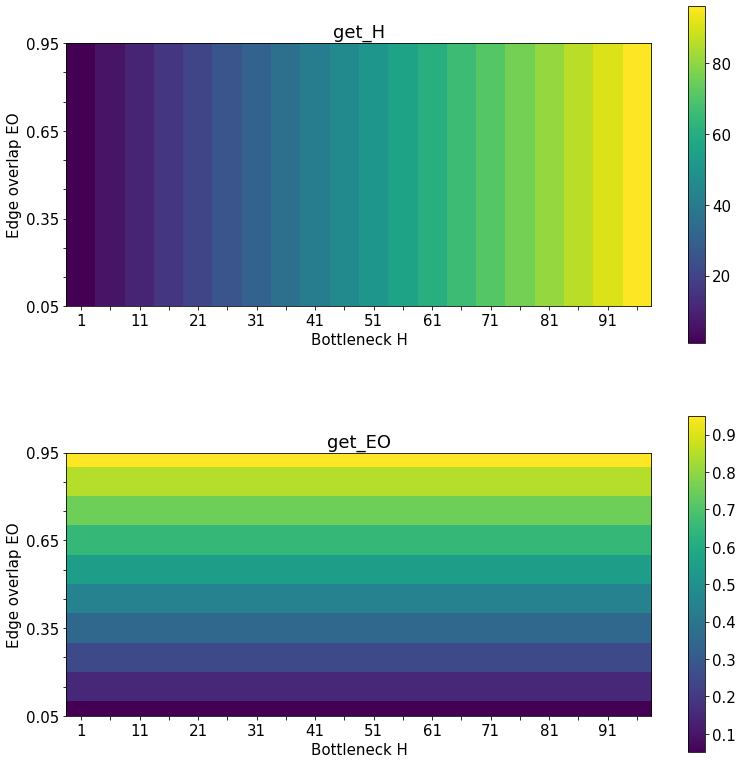

In [99]:
make_H_EO_grid_heatplot(test_dict, Hs, EOs, ['get_H', 'get_EO'], show_every=[2, 3])

## Test dependency of graph parameters on bottleneck H and edge overlap EO 

In [15]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

Selecting 1 largest connected components


In [16]:
W = train_graph.toarray()
W /= W.sum()

In [17]:
# Hs = np.arange(1,101, 5)
# EOs = np.arange(0.05, 1, 0.1)

Hs = [20]
EOs = [0.3, 0.4]

dict_of_dicts_of_statistics = grid_train(Model=net.NetWithoutSampling, train_graph=train_graph,
                                val_ones=val_ones, val_zeros=val_zeros,
                                Hs=Hs, EOs=EOs,
                                test_every=25,
                                max_steps=1500,
                                all_statistics=False)

Start training with H=20 and EO=0.3 (1/2)
Step: 24, Loss: 7.19092, Edge-Overlap: 0.004
Step: 49, Loss: 4.97512, Edge-Overlap: 0.080
Step: 74, Loss: 3.32795, Edge-Overlap: 0.410
Start training with H=20 and EO=0.4 (2/2)
Step: 74, Loss: 3.29108, Edge-Overlap: 0.426


In [13]:
pickle.dump( dict_of_dicts_of_statistics, open( "../data/dictWithoutSampling.p", "wb" ) )
pickle.dump( Hs, open( "../data/HsWithoutSampling.p", "wb" ) )
pickle.dump( EOs, open( "../data/EOsWithoutSampling.p", "wb" ) )

In [19]:
dict_of_dicts_of_statistics = pickle.load( open( "../data/dictWithoutSampling.p", "rb" ) )
Hs = pickle.load( open( "../data/HsWithoutSampling.p", "rb" ) )
EOs = pickle.load( open( "../data/EOsWithoutSampling.p", "rb" ) )

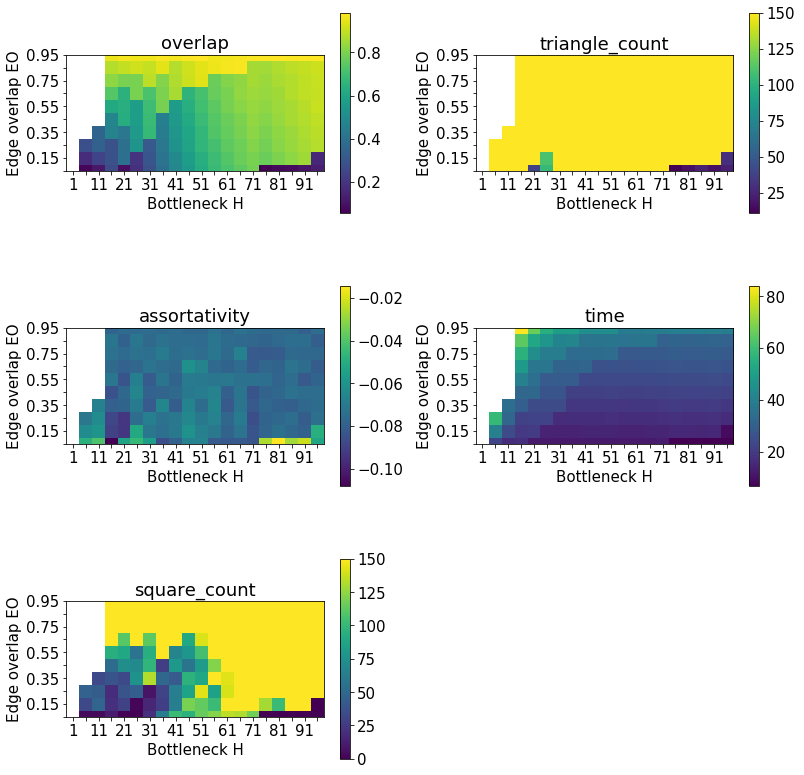

In [20]:
make_H_EO_grid_heatplot(dict_of_dicts_of_statistics=dict_of_dicts_of_statistics,
                        Hs=Hs,
                        EOs=np.around(EOs, decimals=2),
                        keys=['overlap',
                              'triangle_count', 
                              'assortativity',                            
                              'time',
                              'square_count'],
                       show_every=[2, 2])

# make_H_EO_grid_heatplot(dict_of_dicts_of_statistics=dict_of_dicts_of_statistics, Hs=Hs, EOs=EOs, keys=['time'])

# Time plots

In [91]:
def plot_EO_vs_time(overlaps, times, method_keys):
    f, axs = plt.subplots(figsize=(12,12))
    for i in range(len(method_keys)):
        sorting = np.argsort(overlaps[i])
        overlaps_sorted = overlaps[i][sorting]
        times_sorted = times[i][sorting]
        axs.plot(overlaps_sorted, times_sorted, label=method_keys[i])
    plt.legend()
    plt.show()
    return

Extract overlaps and times for each model (here: for each $H$)

In [29]:
overlaps = np.zeros((len(Hs),len(EOs)))
times = np.zeros((len(Hs),len(EOs)))
overlaps.fill(None)
times.fill(None)

for key, dict_of_statistics in dict_of_dicts_of_statistics.items():
    times[key[0], key[1]] = dict_of_statistics['time']
    overlaps[key[0], key[1]] = dict_of_statistics['overlap']

method_keys = [f'H={H}' for H in Hs]

Two options to plot: 
1. Use edge overlaps in EO, i.e. round the exact overlaps to corresponding element in EO. Smoother plots, but less accurate representation.
2. Use the exact overlaps that correspond to the time. Accurate representation, but less smooth plots, and x-axis not uniformly partitioned.

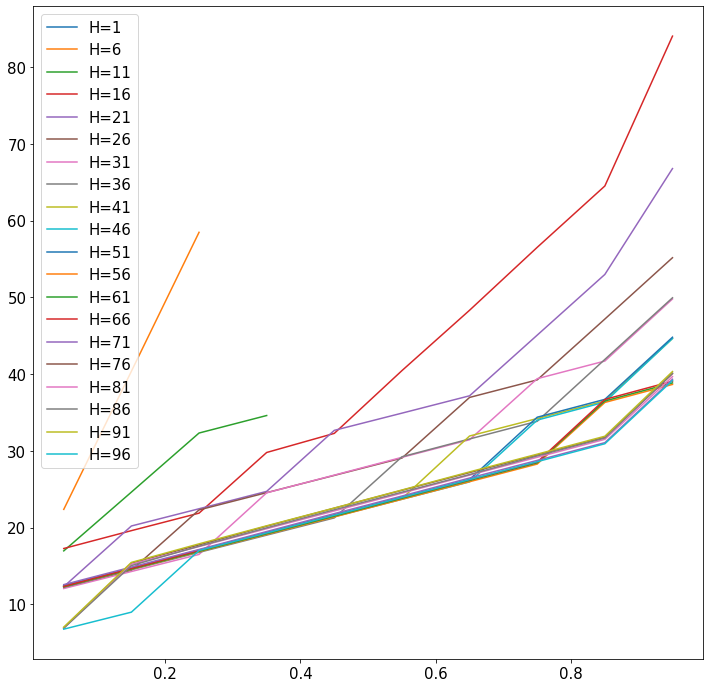

In [95]:
plot_EO_vs_time(np.tile(EOs, (len(Hs), 1)), times, method_keys)

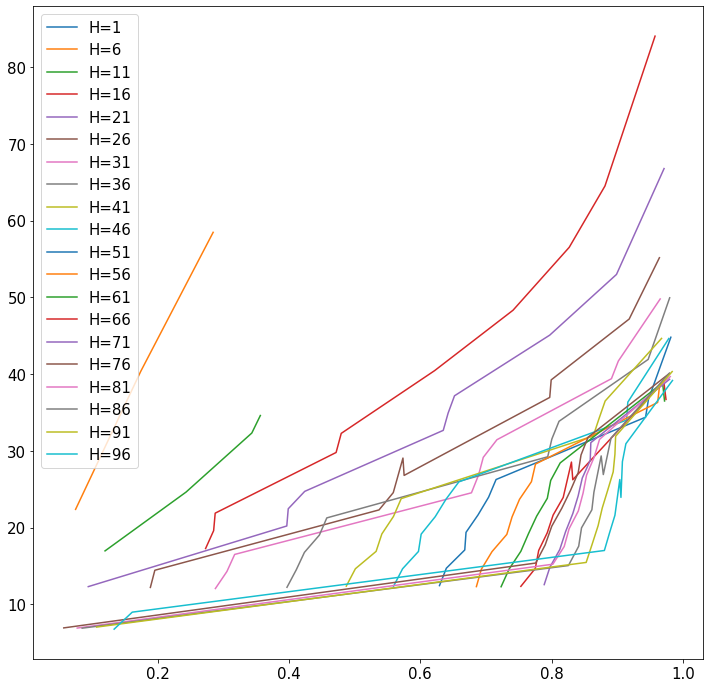

In [94]:
plot_EO_vs_time(overlaps, times, method_keys)

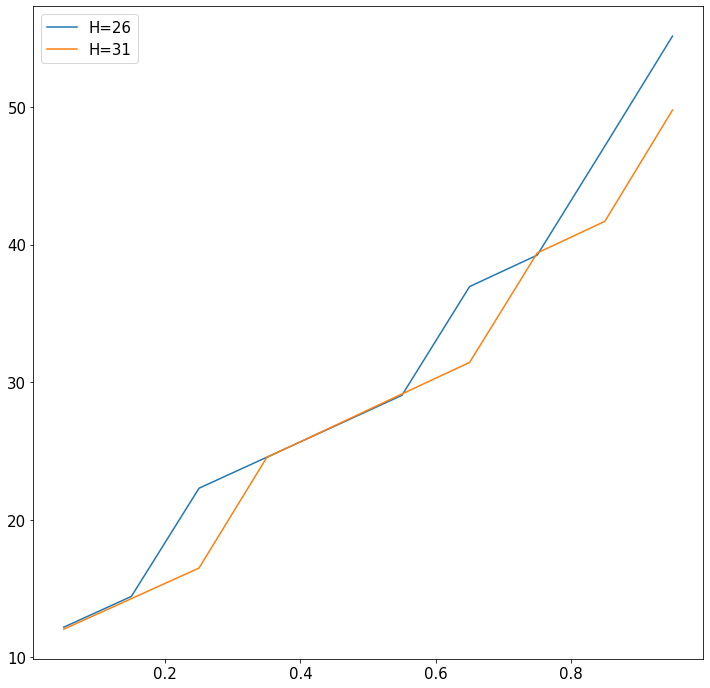

In [80]:
k = np.array([5, 6])
plot_EO_vs_time(overlaps=np.tile(EOs, (len(Hs), 1))[k], times=times[k], method_keys=[method_keys[i] for i in k])

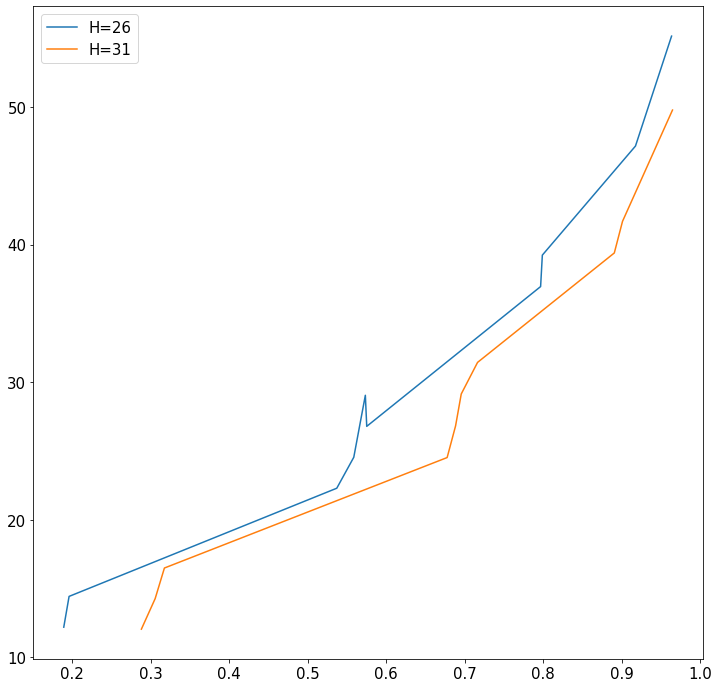

In [92]:
k = np.array([5, 6])
plot_EO_vs_time(overlaps=overlaps[k], times=times[k], method_keys=[method_keys[i] for i in k])